**Задача**:

Имеется массив данных. Среди тех, кто получил карту (issued==1), нужно построить модель для предсказания того, будет ли владелец карты активно пользоваться ей (active==1) по существующим признакам. 

**Необходимые библиотеки**

In [29]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [30]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

**Считываем данные**

In [32]:
data = pd.read_csv(r'card.csv', encoding='latin-1', sep=";")

**Оставляем только пользователей, получивших карту**

In [33]:
data = data[data['issued'] == 1]
data = data.drop('issued', axis=1)

In [34]:
data.head()

,date of birth,age,sex,account,id,active,payroll,segment
0,08.09.1940,76,Female,Long life deposit,01-0102-D-77792953,0,0,Retired
1,21.11.1967,49,Male,Long life deposit,01-0102-D-77789599,0,0,Workers
2,26.08.1958,58,Female,Long life deposit,01-0165-D-77799637,0,0,Retired
3,23.07.1951,65,Female,Long life deposit,01-0165-D-77796328,0,0,Retired
4,11.09.1954,62,Female,Long life deposit,01-0102-D-77797635,0,1,Retired


In [35]:
len(data)

5783

In [36]:
data['account'].value_counts()

ABB individuals       3029
Salary                2522
Long life deposit      163
Salary 6%               40
Salary 3%               21
001-Âêëàä Ñóáñèäèÿ       8
Name: account, dtype: int64

In [37]:
data = data[data['account'] != '001-Âêëàä Ñóáñèäèÿ']

In [38]:
len(data)

5775

In [39]:
data['segment'].value_counts()

Workers      3504
Retired      2035
Students      196
Premium        38
Schoolers       2
Name: segment, dtype: int64

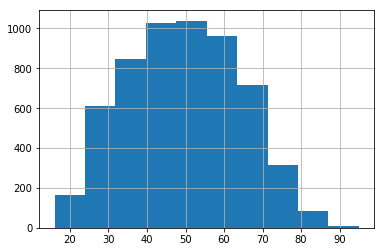

In [40]:
data['age'].hist();

**Подготовка данных**

**sex:** 0 - Male, 1 - Female

**account:** 0 - Long life deposit, 1 - Salary 6%	

**segment:** 0 - Workers, 1 - Retired


In [41]:
data['sex'] = data.sex.apply(lambda x: 0 if x == "Male" else 1)
data['account'] = data.account.apply(lambda x: 0 if x == "ABB individuals" else 1)
data['segment'] = data.segment.apply(lambda x: 0 if x == "Workers" else 1)

In [42]:
# data['sex'] = (data['sex'] == 'Female').astype(int)

**age:** 18-34, 35-54, 55+

In [43]:
data['18-34'] = data.age.apply(lambda x: 1 if x < 35 else 0)
data['35-54'] = data.age.apply(lambda x: 1 if x >= 35 and x < 55 else 0)
data['55+'] = data.age.apply(lambda x: 1 if x >= 55 else 0)

In [44]:
data.head()

,date of birth,age,sex,account,id,active,payroll,segment,18-34,35-54,55+
0,08.09.1940,76,1,1,01-0102-D-77792953,0,0,1,0,0,1
1,21.11.1967,49,0,1,01-0102-D-77789599,0,0,0,0,1,0
2,26.08.1958,58,1,1,01-0165-D-77799637,0,0,1,0,0,1
3,23.07.1951,65,1,1,01-0165-D-77796328,0,0,1,0,0,1
4,11.09.1954,62,1,1,01-0102-D-77797635,0,1,1,0,0,1


Text(0,0.5,'Number of people')

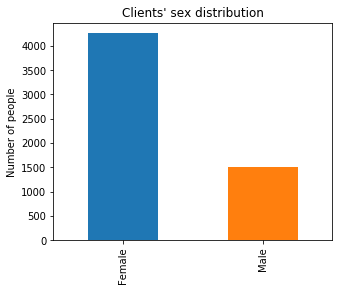

In [45]:
data.sex.value_counts().plot(kind='bar',  figsize=(5,4)) #color=['lightblue', 'lightgreen'],
xticks([1, 0], ['Male', 'Female'])
title('Clients\' sex distribution')
ylabel('Number of people')

Text(0,0.5,'Number of people')

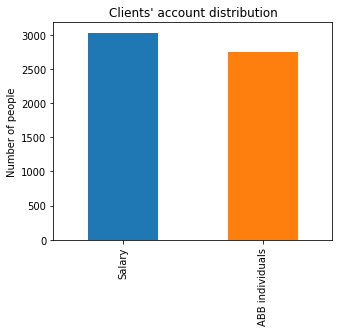

In [46]:
data.account.value_counts().plot(kind='bar', figsize=(5,4)) #, color=['lightyellow', 'lightgrey']
xticks([1, 0], ['ABB individuals', 'Salary'])
title('Clients\' account distribution')
ylabel('Number of people')

Text(0,0.5,'Number of people')

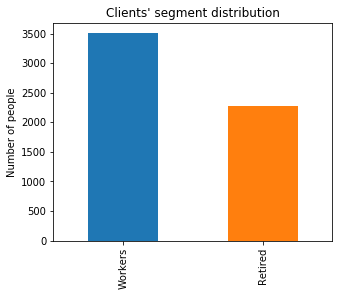

In [47]:
data.segment.value_counts().plot(kind='bar', figsize=(5,4)) #color=['lightblue', 'lightgreen'], 
xticks([1, 0], ['Retired', 'Workers'])
title('Clients\' segment distribution')
ylabel('Number of people')

In [48]:
data.payroll.value_counts()

0    2979
1    2796
Name: payroll, dtype: int64

Text(0,0.5,'Number of people')

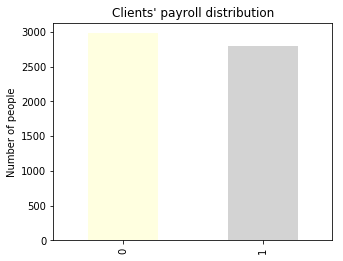

In [49]:
data.payroll.value_counts().plot(kind='bar', color=['lightyellow', 'lightgrey'], figsize=(5,4))
xticks([1, 0], ['1', '0'])
title('Clients\' payroll distribution')
ylabel('Number of people')

**Целевая переменная**

Выборка неслабансирована.

Text(0.5,1,"Clients' activity distribution")

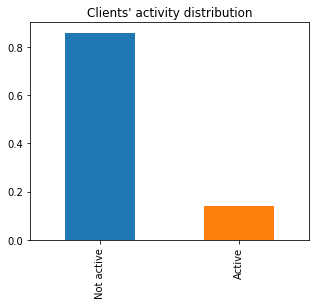

In [50]:
data.active.value_counts(normalize=True).plot(kind='bar', figsize=(5,4)) #, color=['lightblue', 'lightgreen']
xticks([1, 0], ['Active', 'Not active'])
title('Clients\' activity distribution')

In [51]:
data.active.value_counts()

0    4960
1     815
Name: active, dtype: int64

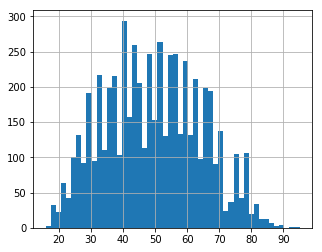

In [52]:
data['age'].hist(figsize=(5,4),bins=50)#, color=['lightgreen']
plt.show()

In [53]:
data.age.describe()

count    5775.000000
mean       49.438615
std        15.003798
min        16.000000
25%        38.000000
50%        49.000000
75%        61.000000
max        95.000000
Name: age, dtype: float64

**Разделение на train/test set**

In [54]:
data.head()

,date of birth,age,sex,account,id,active,payroll,segment,18-34,35-54,55+
0,08.09.1940,76,1,1,01-0102-D-77792953,0,0,1,0,0,1
1,21.11.1967,49,0,1,01-0102-D-77789599,0,0,0,0,1,0
2,26.08.1958,58,1,1,01-0165-D-77799637,0,0,1,0,0,1
3,23.07.1951,65,1,1,01-0165-D-77796328,0,0,1,0,0,1
4,11.09.1954,62,1,1,01-0102-D-77797635,0,1,1,0,0,1


In [55]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3869, 9), (3869,), (1906, 9), (1906,))

**Увеличим количество объектов миноритарного класса в train set (oversampling)**

In [62]:
def oversample(x_train1, x_test):
    x_train = x_train1

    x_train = x_train.append(x_train1[x_train1['active'] == 1])
    x_train = x_train.append(x_train1[x_train1['active'] == 1])

    # shuffle data
    x_train = x_train.sample(frac=1).reset_index(drop=True) 
    y_train = x_train['active']
    x_train = x_train.drop('active',1)
    x_test = x_test.drop('active',1)
    return x_train, y_train, x_test

In [63]:
x_train, y_train, x_test = oversample(x_train, x_test)

In [68]:
def check_models(feature_sets, models):
    i = 0
    for f in feature_sets:
        print(i)
        x = data[f]
        y = data['active']
        # Splitting on train/test set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=48)
        x_train, y_train, x_test = oversample(x_train, x_test)
        for m in models:
            m.fit(x_train, y_train)
            predicted = m.predict(x_test)
            print(m)
            print(metrics.accuracy_score(y_test, predicted, normalize=True))
            print(metrics.confusion_matrix(y_test, predicted))
            print('-----------------------------------------------------')
                   
        i += 1

In [69]:
data.columns

Index(['date of birth', 'age', 'sex', 'account', 'id', 'active', 'payroll',
       'segment', '18-34', '35-54', '55+'],
      dtype='object')

In [66]:
feature_sets = []
feature_sets.append(['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment'])
feature_sets.append(['active','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment'])
# feature_sets.append(['active','18-34', '35-54', '55+', 'account', 'payroll', 'segment'])
# feature_sets.append(['active', 'age','18-34', '35-54', '55+', 'account', 'payroll', 'segment'])

models = []
models.append(KNeighborsClassifier(n_neighbors=10))
# models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(SVC())
models.append(SGDClassifier())

In [70]:
check_models(feature_sets, models)

0
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
0.7974816369359916
[[1467  181]
 [ 205   53]]
-----------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.7927597061909759
[[1441  207]
 [ 188   70]]
-----------------------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8347324239244491
[[1549   99]
 [ 216   42]]
------------

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.1353620146904512
[[   0 1648]
 [   0  258]]
-----------------------------------------------------
1
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
0.8137460650577125
[[1508  140]
 [ 215   43]]
-----------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [32]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]
X, y, _ = oversample(X, data[['active', 'age']])

In [33]:
param_grid = [{'penalty':['l1', 'l2'],
               'C':[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 1.2],
               'tol':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 0.5, 2]}]

grid = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', verbose=2)

In [34]:
grd = grid.fit(X, y)

Fitting 3 folds for each of 112 candidates, totalling 336 fits
[CV] C=0.0001, penalty=l1, tol=1e-05 .................................
[CV] ........................ C=0.0001, penalty=l1, tol=1e-05 -   0.0s
[CV] C=0.0001, penalty=l1, tol=1e-05 .................................
[CV] ........................ C=0.0001, penalty=l1, tol=1e-05 -   0.0s
[CV] C=0.0001, penalty=l1, tol=1e-05 .................................
[CV] ........................ C=0.0001, penalty=l1, tol=1e-05 -   0.0s
[CV] C=0.0001, penalty=l1, tol=0.0001 ................................
[CV] ....................... C=0.0001, penalty=l1, tol=0.0001 -   0.0s
[CV] C=0.0001, penalty=l1, tol=0.0001 ................................
[CV] ....................... C=0.0001, penalty=l1, tol=0.0001 -   0.0s
[CV] C=0.0001, penalty=l1, tol=0.0001 ................................
[CV] ....................... C=0.0001, penalty=l1, tol=0.0001 -   0.0s
[CV] C=0.0001, penalty=l1, tol=0.001 .................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................ C=0.0001, penalty=l2, tol=1e-05 -   0.0s
[CV] C=0.0001, penalty=l2, tol=1e-05 .................................
[CV] ........................ C=0.0001, penalty=l2, tol=1e-05 -   0.0s
[CV] C=0.0001, penalty=l2, tol=0.0001 ................................
[CV] ....................... C=0.0001, penalty=l2, tol=0.0001 -   0.0s
[CV] C=0.0001, penalty=l2, tol=0.0001 ................................
[CV] ....................... C=0.0001, penalty=l2, tol=0.0001 -   0.0s
[CV] C=0.0001, penalty=l2, tol=0.0001 ................................
[CV] ....................... C=0.0001, penalty=l2, tol=0.0001 -   0.0s
[CV] C=0.0001, penalty=l2, tol=0.001 .................................
[CV] ........................ C=0.0001, penalty=l2, tol=0.001 -   0.0s
[CV] C=0.0001, penalty=l2, tol=0.001 .................................
[CV] ........................ C=0.0001, penalty=l2, tol=0.001 -   0.0s
[CV] C=0.0001, penalty=l2, tol=0.001 .................................
[CV] .

[CV] .......................... C=0.01, penalty=l1, tol=1e-05 -   0.0s
[CV] C=0.01, penalty=l1, tol=1e-05 ...................................
[CV] .......................... C=0.01, penalty=l1, tol=1e-05 -   0.0s
[CV] C=0.01, penalty=l1, tol=0.0001 ..................................
[CV] ......................... C=0.01, penalty=l1, tol=0.0001 -   0.0s
[CV] C=0.01, penalty=l1, tol=0.0001 ..................................
[CV] ......................... C=0.01, penalty=l1, tol=0.0001 -   0.0s
[CV] C=0.01, penalty=l1, tol=0.0001 ..................................
[CV] ......................... C=0.01, penalty=l1, tol=0.0001 -   0.0s
[CV] C=0.01, penalty=l1, tol=0.001 ...................................
[CV] .......................... C=0.01, penalty=l1, tol=0.001 -   0.0s
[CV] C=0.01, penalty=l1, tol=0.001 ...................................
[CV] .......................... C=0.01, penalty=l1, tol=0.001 -   0.0s
[CV] C=0.01, penalty=l1, tol=0.001 ...................................
[CV] .

[CV] ........................... C=0.1, penalty=l2, tol=1e-05 -   0.0s
[CV] C=0.1, penalty=l2, tol=1e-05 ....................................
[CV] ........................... C=0.1, penalty=l2, tol=1e-05 -   0.0s
[CV] C=0.1, penalty=l2, tol=1e-05 ....................................
[CV] ........................... C=0.1, penalty=l2, tol=1e-05 -   0.0s
[CV] C=0.1, penalty=l2, tol=0.0001 ...................................
[CV] .......................... C=0.1, penalty=l2, tol=0.0001 -   0.0s
[CV] C=0.1, penalty=l2, tol=0.0001 ...................................
[CV] .......................... C=0.1, penalty=l2, tol=0.0001 -   0.0s
[CV] C=0.1, penalty=l2, tol=0.0001 ...................................
[CV] .......................... C=0.1, penalty=l2, tol=0.0001 -   0.0s
[CV] C=0.1, penalty=l2, tol=0.001 ....................................
[CV] ........................... C=0.1, penalty=l2, tol=0.001 -   0.0s
[CV] C=0.1, penalty=l2, tol=0.001 ....................................
[CV] .

[CV] ............................... C=0.5, penalty=l2, tol=1 -   0.0s
[CV] C=0.5, penalty=l2, tol=1 ........................................
[CV] ............................... C=0.5, penalty=l2, tol=1 -   0.0s
[CV] C=0.5, penalty=l2, tol=1 ........................................
[CV] ............................... C=0.5, penalty=l2, tol=1 -   0.0s
[CV] C=0.5, penalty=l2, tol=0.5 ......................................
[CV] ............................. C=0.5, penalty=l2, tol=0.5 -   0.0s
[CV] C=0.5, penalty=l2, tol=0.5 ......................................
[CV] ............................. C=0.5, penalty=l2, tol=0.5 -   0.0s
[CV] C=0.5, penalty=l2, tol=0.5 ......................................
[CV] ............................. C=0.5, penalty=l2, tol=0.5 -   0.0s
[CV] C=0.5, penalty=l2, tol=2 ........................................
[CV] ............................... C=0.5, penalty=l2, tol=2 -   0.0s
[CV] C=0.5, penalty=l2, tol=2 ........................................
[CV] .

[CV] ........................... C=1.2, penalty=l1, tol=1e-05 -   0.1s
[CV] C=1.2, penalty=l1, tol=0.0001 ...................................
[CV] .......................... C=1.2, penalty=l1, tol=0.0001 -   0.1s
[CV] C=1.2, penalty=l1, tol=0.0001 ...................................
[CV] .......................... C=1.2, penalty=l1, tol=0.0001 -   0.1s
[CV] C=1.2, penalty=l1, tol=0.0001 ...................................
[CV] .......................... C=1.2, penalty=l1, tol=0.0001 -   0.1s
[CV] C=1.2, penalty=l1, tol=0.001 ....................................
[CV] ........................... C=1.2, penalty=l1, tol=0.001 -   0.0s
[CV] C=1.2, penalty=l1, tol=0.001 ....................................
[CV] ........................... C=1.2, penalty=l1, tol=0.001 -   0.0s
[CV] C=1.2, penalty=l1, tol=0.001 ....................................
[CV] ........................... C=1.2, penalty=l1, tol=0.001 -   0.0s
[CV] C=1.2, penalty=l1, tol=0.01 .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:    4.3s finished


** Оптимизация параметров моделей**

**LogisticRegression**

In [35]:
grd.best_params_

{'C': 1, 'penalty': 'l2', 'tol': 1e-05}

In [36]:
est = grd.best_estimator_

In [37]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
x_train, y_train, x_test = oversample(x_train, x_test)

In [39]:
est.fit(x_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)

In [40]:
pred = est.predict(x_test)

In [41]:
print(metrics.accuracy_score(y_test, pred, normalize=False), '/', len(y_test))
print(metrics.accuracy_score(y_test, pred, normalize=True))
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
print(metrics.auc(fpr, tpr))

1583 / 1909
0.8292299633315873
[[1534   95]
 [ 231   49]]
             precision    recall  f1-score   support

          0       0.87      0.94      0.90      1629
          1       0.34      0.17      0.23       280

avg / total       0.79      0.83      0.81      1909

0.558341006752609


**KNeighborsClassifier**

In [42]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]
X, y, _ = oversample(X, data[['active', 'age']])

In [43]:
param_grid = [{'n_neighbors':[3, 5, 10, 15],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'leaf_size': [30, 40, 50],
               'metric': ['euclidean', 'manhattan'],
               'p':[3, 4, 5]}]

grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', verbose=2)

In [44]:
grid = grid.fit(X, y)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 
[CV]  algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 
[CV]  algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 
[CV]  algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 
[CV]  algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 
[CV]  algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 
[CV]  algorithm=auto, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 -   0.0s
[CV] al

[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=10, p=5 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=10, p=5 
[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=10, p=5 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=3 
[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=3 
[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=3 
[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=30, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=auto, leaf_size=30, metric=manhattan, n_ne

[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=5, p=5 -   0.0s
[CV] algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=40, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=auto, leaf_size=40, metric=manhattan, n_nei

[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=4 
[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=4 
[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=4 -   0.0s
[CV] algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=5 
[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=5 -   0.0s
[CV] algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=5 
[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=5 -   0.0s
[CV] algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=5 
[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=3, p=5 -   0.0s
[CV] algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=5, p=3 
[CV]  algorithm=auto, leaf_size=50, metric=manhattan, n_neighbors=5, p

[CV]  algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=3 
[CV]  algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=3 -   0.1s
[CV] algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=3 
[CV]  algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=3 -   0.1s
[CV] algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=30, metric=euclidean, n_neighbors=15, p=5

[CV]  algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=3 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=4 
[CV]  algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=4 
[CV]  algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=4 
[CV]  algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=5 
[CV]  algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=5 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=5 
[CV]  algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=5 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=euclidean, n_neighbors=5, p=5 
[CV]  algo

[CV]  algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=5 
[CV]  algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=5 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=5 
[CV]  algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=5 -   0.0s
[CV] algorithm=ball_tree, leaf_size=40, metric=manhattan, n_neighbors=15, p=5

[CV]  algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=ball_tree, leaf_size=50, metric=manhattan, n_neighbors=10, p=5

[CV]  algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=3, p=5 -   0.0s
[CV] algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=3, p=5 
[CV]  algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=3, p=5 -   0.0s
[CV] algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=3 
[CV]  algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=3 
[CV]  algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=3 
[CV]  algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=4 
[CV]  algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=4 -   0.0s
[CV] algorithm=kd_tree, leaf_size=30, metric=manhattan, n_neighbors=5, p=4 
[CV]  algorithm=kd_tree, leaf_size

[CV]  algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=10, p=5 -   0.0s
[CV] algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=3 
[CV]  algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=3 
[CV]  algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=3 
[CV]  algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 -   0.0s
[CV] algorithm=kd_tree, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=kd_tre

[CV]  algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=3 
[CV]  algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=3 -   0.0s
[CV] algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=4 
[CV]  algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=4 
[CV]  algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=4 
[CV]  algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=4 -   0.0s
[CV] algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=5 
[CV]  algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=5 -   0.0s
[CV] algorithm=kd_tree, leaf_size=50, metric=euclidean, n_neighbors=10, p=5 
[CV]  algorithm=kd_tre

[CV]  algorithm=kd_tree, leaf_size=50, metric=manhattan, n_neighbors=15, p=5 -   0.0s
[CV] algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 
[CV]  algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 -   0.3s
[CV] algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 
[CV]  algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 
[CV]  algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 
[CV]  algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 
[CV]  algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 -   0.1s
[CV] algorithm=brute, leaf_size=30, metric=euclidean, n_neighbors=3, p=4 
[CV]  algorithm=brute, leaf_size=30, metric=euclidean, 

[CV]  algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=5, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=5, p=5 
[CV]  algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=5, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=5, p=5 
[CV]  algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=5, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=3 
[CV]  algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=30, metric=manhattan, n_neighbors=10, p=4 
[CV]  algorithm=brute, leaf_size=30, metric=manhatt

[CV]  algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 
[CV]  algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=5 
[CV]  algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=5 
[CV]  algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=5 
[CV]  algorithm=brute, leaf_size=40, metric=euclidean, n_neighbors=15, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=40, metric=manhattan, n_neighbors=3, p=3 
[CV]  algorithm=brute, leaf_size=40, metric=manhattan, n_neighbors=3, p=3 -   0.1s
[CV] algorithm=brute, leaf_size=40, metric=manhattan, n_neighbors=3, p=3 
[CV]  algorithm=brute, leaf_size=40, metric=manha

[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=3 -   0.3s
[CV] algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=4 
[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=4 -   0.3s
[CV] algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=4 
[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=4 
[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=5 
[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=5 
[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=5 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=euclidean, n_neighbors=5, p=5 
[CV]  algorithm=brute, leaf_size=50, metric=euclidean, n_n

[CV]  algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=3 
[CV]  algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=3 
[CV]  algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=3 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=4 
[CV]  algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=4 -   0.2s
[CV] algorithm=brute, leaf_size=50, metric=manhattan, n_neighbors=15, p=5 
[CV]  algorithm=brute, leaf_size=50, metric=ma

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:   57.0s finished


In [45]:
print(grid.best_params_)
est = grid.best_estimator_

{'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 15, 'p': 3}


In [46]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
x_train, y_train, x_test = oversample(x_train, x_test)

In [48]:
est.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=15, p=3,
           weights='uniform')

In [49]:
pred = est.predict(x_test)

In [50]:
print(metrics.accuracy_score(y_test, pred, normalize=False), '/', len(y_test))
print(metrics.accuracy_score(y_test, pred, normalize=True))
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
print(metrics.auc(fpr, tpr))

1446 / 1909
0.7574646411733892
[[1352  277]
 [ 186   94]]
             precision    recall  f1-score   support

          0       0.88      0.83      0.85      1629
          1       0.25      0.34      0.29       280

avg / total       0.79      0.76      0.77      1909

0.582835657283171


**DecisionTreeClassifier**

In [51]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]
X, y, _ = oversample(X, data[['active', 'age']])

In [52]:
param_grid = [{'criterion':['entropy', 'gini'],
               'max_features': [ 3, 5, 7, 8],
               'max_depth': [3, 5, 7, 9, 100]
             }]

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='roc_auc', verbose=2)

In [53]:
grd = grid.fit(X, y)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] criterion=entropy, max_depth=3, max_features=3 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=3 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=3 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=3 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=3 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=3 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=5 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=5 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=5 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=5 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=5 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=5 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=7 ..................
[CV] ......... 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......... criterion=entropy, max_depth=3, max_features=8 -   0.0s
[CV] criterion=entropy, max_depth=3, max_features=8 ..................
[CV] ......... criterion=entropy, max_depth=3, max_features=8 -   0.0s
[CV] criterion=entropy, max_depth=5, max_features=3 ..................
[CV] ......... criterion=entropy, max_depth=5, max_features=3 -   0.0s
[CV] criterion=entropy, max_depth=5, max_features=3 ..................
[CV] ......... criterion=entropy, max_depth=5, max_features=3 -   0.0s
[CV] criterion=entropy, max_depth=5, max_features=3 ..................
[CV] ......... criterion=entropy, max_depth=5, max_features=3 -   0.0s
[CV] criterion=entropy, max_depth=5, max_features=5 ..................
[CV] ......... criterion=entropy, max_depth=5, max_features=5 -   0.0s
[CV] criterion=entropy, max_depth=5, max_features=5 ..................
[CV] ......... criterion=entropy, max_depth=5, max_features=5 -   0.0s
[CV] criterion=entropy, max_depth=5, max_features=5 ..................
[CV] .

[CV] ............ criterion=gini, max_depth=5, max_features=5 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=5 .....................
[CV] ............ criterion=gini, max_depth=5, max_features=5 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=7 .....................
[CV] ............ criterion=gini, max_depth=5, max_features=7 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=7 .....................
[CV] ............ criterion=gini, max_depth=5, max_features=7 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=7 .....................
[CV] ............ criterion=gini, max_depth=5, max_features=7 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=8 .....................
[CV] ............ criterion=gini, max_depth=5, max_features=8 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=8 .....................
[CV] ............ criterion=gini, max_depth=5, max_features=8 -   0.0s
[CV] criterion=gini, max_depth=5, max_features=8 .....................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.6s finished


In [54]:
print(grd.best_params_)
est = grd.best_estimator_

{'criterion': 'gini', 'max_depth': 100, 'max_features': 3}


In [55]:
y = data['active']
X = data[['active', 'age','18-34', '35-54', '55+', 'sex', 'account', 'payroll', 'segment']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
x_train, y_train, x_test = oversample(x_train, x_test)

In [57]:
est.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [58]:
pred = est.predict(x_test)

In [59]:
print(metrics.accuracy_score(y_test, pred, normalize=False), '/', len(y_test))
print(metrics.accuracy_score(y_test, pred, normalize=True))
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
print(metrics.auc(fpr, tpr))

1497 / 1909
0.7841801990570979
[[1426  203]
 [ 209   71]]
             precision    recall  f1-score   support

          0       0.87      0.88      0.87      1629
          1       0.26      0.25      0.26       280

avg / total       0.78      0.78      0.78      1909

0.564477549767605
